# SwabSeq Primer Design

Here we will design 1536 unique i5 and i7 indicies. This will enable the end user to detect any "index hopping" between wells. They will satify the following criteria:

- Minimum Levenshtein Distance of 3 between any two indicies
- No homopolymer repeats > 2 nt
- Minimized homo- and hetero-dimerization potential

First, let's generate the pool of all potential 10 nt indicies satisfying our Levenshtein Distance constraints. From [Ashlock et. al 2012](https://doi.org/10.1016/j.biosystems.2012.06.005), we know there are exactly 11,743 of them. This will take ~30 mins, so we've provided the pre-calculated set.

In [1]:
import random
import itertools
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

# external depends
import Levenshtein
import primer3


def conways_lexicode(all_idx, d=3):
    """
    Peforms John Conway's (RIP) Lexicode Algorithm (Ashlock 2012). Given an ordered set of
    indicies (all_idx) and an empty set (pool), select an index from all_idx and place it
    in pool if it is at an edit distance of d or more from every index in pool.
    Obviously, this is an inefficient way of calculating things, but the
    complexity of edit metric spaces means this is almost as good as it gets...

    Reference:
        https://doi.org/10.1016/j.biosystems.2012.06.005
    Input:
        all_idx - an iterator that contains a all indicies
        d - the minimum distance a idx must be to be included in pool
    Output:
        pool - a list of all the barcodes satisfying the constraint
    """
    pool = []
    pool.append(next(all_idx))
    for test_idx in all_idx:
        for pool_idx in pool:
            if Levenshtein.distance(test_idx, pool_idx) < d:
                break
        else:
            pool.append(test_idx)
    return pool

# Generate the indicies
# ten_mers = (''.join(x) for x in itertools.product('ACGT', repeat=10))
# ten_mers_d3 = conways_lexicode(ten_mers, d=3)

# Instead, load the indices
ten_mers_d3 = []
with open('./ten-mer_d3.txt', 'r') as f:
    for line in f:
        ten_mers_d3.append(line.rstrip())

While these indices are far apart, we need to remove the repetative and highly GC rich species 

In [2]:
ten_mers_filter = []
for idx in ten_mers_d3:
    gc = (idx.count('G') + idx.count('C')) / len(idx)
    if gc > 0.65 or gc < 0.35:
        continue
    elif any(len(list(x)) > 2 for _,x in itertools.groupby(idx)):
        continue
#     elif idx[:2] == 'GG':
#         continue
    else:
        ten_mers_filter.append(idx)
        
print(f'Primers remaining after filter - {len(ten_mers_filter)}')
print(f'Possible unique pairs after filter - {len(ten_mers_filter)//2}')

Primers remaining after filter - 5299
Possible unique pairs after filter - 2649


## Primer Sets

SwabSeq has 2 different primer sets - one for SARS-CoV2 (S2) and one for the housekeeping gene RPP30. It should be noted that in the genbank files, our primers are oriented as follows:

```
s2:    P5_Forward----------Reverse_P7
rpp30: P5_Reverse----------Forward_P7
```

We will ignore the "Forward"/"Reverse" primer distinction, and instead orient our indices based on the P5/P7 sequences, as this is what the sequencer will do regardless.

In [3]:
# illumina amplicons must start and end with these sequences
p5 = 'AATGATACGGCGACCACCGAGATCTACAC'
p7 = 'CAAGCAGAAGACGGCATACGAGAT'

s2_f = 'GCTGGTGCTGCAGCTTATTA'
s2_r = 'AGGGTCAAGTGCACAGTCTA'

rpp30_r = 'GAGCGGCTGTCTCCACAAGT'
rpp30_f = 'AGATTTGGACCTGCGAGCG'

# capture all of the primers that will be in each well
# data structure -> {orientation:{idx:{s2:seq, rpp30:seq}, ...}}
s2_dict = defaultdict(lambda: defaultdict(dict))
for idx in ten_mers_filter:      
    # note eric & aaron paired designed the amplicons as follows:
    # s2:    P5_Forward----------Reverse_P7
    # rpp30: P5_Reverse----------Forward_P7
    s2_dict['F'][idx] = {'S2':f'{p5}{idx}{s2_f}', 'RPP30':f'{p5}{idx}{rpp30_r}'}
    s2_dict['R'][idx] = {'S2':f'{p7}{idx}{s2_r}', 'RPP30':f'{p7}{idx}{rpp30_f}'}

Since the calculations take some time, we can mash all of these primer sets together and use `multiprocessing` to parallelize the tasks. We'll also drop the data into a `Pandas` `DataFrame` to make visualization/etc easier.

In [4]:
def calc_self_props(idx_dict):
    """
    Use Primer3 to calculate hairpin and self-dimer properties. Note we have to 
    trim sequences to 60 nt (removing the 5' end) to work with Primer3. While 
    not ideal, this is probably safe as primer dimers come from the 3' end and
    this is part of the common region of the primer.
    
    Input:
        idx_dict - must have primer:str key:val pair
    Output:
        out_dict - Adds haripin and self-dimer Tm and dG
    Requires:
        primer3-py - pip install primer3-py
    """
    # be good - avoid side-effects
    out_dict = {key:val for key,val in idx_dict.items()}
    hairpin = primer3.calcHairpin(out_dict['primer'][-60:]).todict()
    self = primer3.calcHomodimer(out_dict['primer'][-60:]).todict()
    out_dict['hairpin_dg'] = hairpin['dg']
    out_dict['hairpin_tm'] = hairpin['tm']
    out_dict['self_dg'] = self['dg']
    out_dict['self_tm'] = self['tm']
    return(out_dict)

# flatten the dict for easy proc and export to pandas
# {orientation:{idx:{s2:seq, rpp30:seq}, ...}} -> {orientation:xx, idx:xx, s2:xx, rpp30:xx}
flat_s2 = []
for orientation, idx_dict in s2_dict.items():
    for idx, well_dict in idx_dict.items():
        for primer_set, seq in well_dict.items():
            flat_s2.append({'orientation':orientation, 'idx':idx, 'set':primer_set, 'primer':seq})
                
with multiprocessing.Pool() as pool:
    self_props = pd.DataFrame(pool.map(calc_self_props, flat_s2))

Let's visualize the properties to get a sense for what's going on with our potential primers. First the hairpin dG's

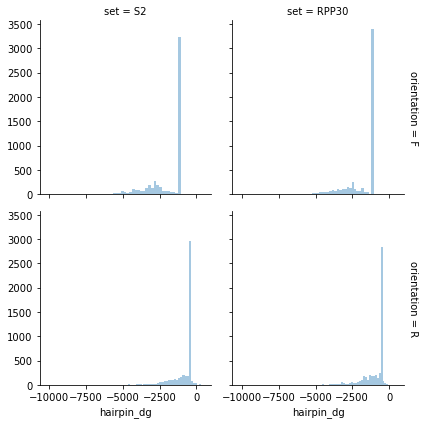

In [5]:
g = sns.FacetGrid(self_props, row='orientation', col='set', margin_titles=True)
g.map(sns.distplot, "hairpin_dg", kde=False)

We can appreciate that the hairpin dG's are binned to a single value. Next, the self-dimer dG's

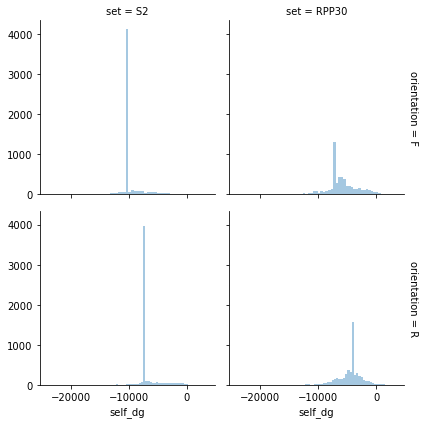

In [6]:
g = sns.FacetGrid(self_props, row='orientation', col='set', margin_titles=True)
g.map(sns.distplot, "self_dg", kde=False)

Here we have more of a spread in dG's. With the S2 primers being more likely to self-dimerize.

## Finding Optimal Pairs

Let's drop the bottom 5% from all of these distributions, and take the intersection within each orientation. The goal here being to find a common set of indicies that work well for either the forward or reverse orientations. We can then compare across orientations (excluding identical indices) to find 1536 forward and 1536 reverse primers that have minimized self- and cross-reactivity.

In [7]:
cutoffs = self_props.groupby(['set', 'orientation']).agg(
    self_dg_cutoff=('self_dg', lambda x: np.quantile(x, 0.05)),
    hairpin_dg_cutoff=('hairpin_dg', lambda x: np.quantile(x, 0.05))
)
cutoffs

self_dg_cutoff  hairpin_dg_cutoff
set   orientation                                   
RPP30 F             -10112.849083       -4121.201989
      R              -8069.037827       -2856.675085
S2    F             -10779.838179       -4630.436482
      R              -7567.754177       -2502.688987

Let's find indices that pass our cutoffs in all our primer sets

In [8]:
good_idx = (pd.merge(self_props, cutoffs, on=['set','orientation'])
 .query('hairpin_dg > hairpin_dg_cutoff & self_dg > self_dg_cutoff')
 .groupby(['orientation', 'idx']) 
 .size()
 .reset_index(name='counts')
 .query('counts == 2')
)

good_idx.groupby('orientation').size()

orientation
F    4544
R    4663
dtype: int64

Next, we'll take the intersection of these two sets of barcodes to get pairs that are good in either the forward or reverse configuration. Since the well heterodimer calculation takes a while, we'll randomly sample 500,000 pairs from all of possible combinations. Given the previous filtering steps and Levenshtein distance constraint, we are pretty confident these will be good primers. One can easily scale this up to ~1,000,000 draws, but some initial profiling suggests that the dG values all get binned on to a single point (which is reasonable given that only 10 nt of the entire ~60nt primer is changing).

In [9]:
%%time
f_set = set(good_idx.query('orientation == "F"')['idx'])
r_set = set(good_idx.query('orientation == "R"')['idx'])
good_set = f_set.intersection(r_set)
print(f'Barcodes remaining - {len(good_set)}')
print(f'Possible unique pairs remaining - {len(good_set)//2}')

# ensure we get the same sampling each time
# sort good_set since dictionaries have no order
# for whatever reason random.shuffle would not obey the seed
combos = list(itertools.combinations(sorted(good_set), 2))
rand_idx = random.Random(42).sample(range(len(combos)), len(combos))
combos_shuf = [combos[x] for x in rand_idx]

print('Random Test! The two lists should be the same...')
print(f'[1609253, 6865793, 4057987, 8030505]\n{rand_idx[-4:]}')

sample_depth = 500000
pairs = combos_shuf[:sample_depth]

Barcodes remaining - 4060
Possible unique pairs remaining - 2030
Random Test! The two lists should be the same...
[1609253, 6865793, 4057987, 8030505]
[1609253, 6865793, 4057987, 8030505]
CPU times: user 11.3 s, sys: 424 ms, total: 11.8 s
Wall time: 11.8 s


Now run the well cross-hybridization calculation. Should take ~10 mins on 64 cores.

In [10]:
%%time
def calc_well_heterodimers(well_combo):
    """
    Generate all combinations of possible primer pairs within one well.
    Calculate the dG and report the min value.
    
    Input:
        well_combo: [(f_index, {s2:seq, rpp30:seq}), (r_index, {s2:seq, rpp30:seq})]
    Output:
        (f_index, r_index, dG)
    Depends:
        primer3 - pip install primer3-py
    """
    idx, dict_store = list(zip(*well_combo))
    primers = itertools.chain.from_iterable(x.values() for x in dict_store)
    # pairs = itertools.permutations(primers, 2)
    pairs = itertools.combinations(primers, 2)
    dG = min(primer3.calcHeterodimer(x[-60:], y).dg for x,y in pairs)
    return((*idx, dG))

s2_wells = [((f, s2_dict['F'][f]), (r, s2_dict['R'][r])) for f,r in pairs]

with multiprocessing.Pool() as pool:
    s2_well_dG = pool.map(calc_well_heterodimers, s2_wells)

CPU times: user 12.7 s, sys: 1.6 s, total: 14.3 s
Wall time: 8min 12s


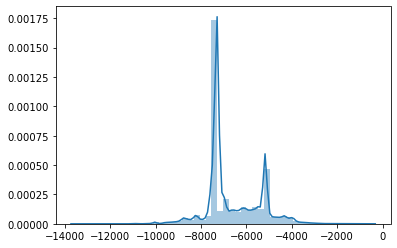

In [11]:
sns.distplot([x[2] for x in s2_well_dG])

There seems to be two different populations. Given the depth of sampling, this is not likely driven by specific indices, rather from the primers themselves. Let's sort by dG and iterate through these pairs in a greedy fashion, ensuring that the forward and reverse primers never get used twice.

In [12]:
# since there will be a lot of ties, first sort by f index then sort by dG
# this should ensure that we get the same set of primers everytime
s2_well_dG.sort(key=lambda x: x[0])
s2_well_dG.sort(key=lambda x: x[2], reverse=True)
print(f'Length of input - {len(s2_well_dG)}')

final_pairs = []
used_idx = set()
for f, r, dG in s2_well_dG:
    if f in used_idx or r in used_idx:
        continue
    else:
        final_pairs.append((f, r, dG))
        used_idx.update((f,r))
        
print(f'Total unique index pairs found - {len(final_pairs)}')

Length of input - 500000
Total unique index pairs found - 2024


Let's see what our final dG distribution looks like

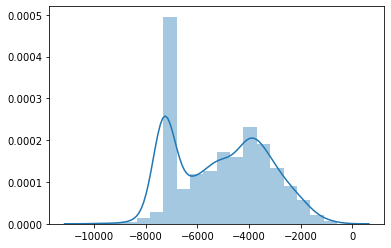

In [13]:
sns.distplot([x[2] for x in final_pairs])

Looks good! Now grab as many primer sets as you need and output to a nice tsv

In [14]:
# write them out together for debugging
with open('./primer-set.tsv', 'w') as out_file:
    for f, r, dG in final_pairs:
        # output as: f_idx, f_primer, set, r_idx, r_primer
        print(f'{f}\t{s2_dict["F"][f]["RPP30"]}\tRPP30\t{r}\t{s2_dict["R"][r]["RPP30"]}', file=out_file)
        print(f'{f}\t{s2_dict["F"][f]["S2"]}\tS2\t{r}\t{s2_dict["R"][r]["S2"]}', file=out_file)
        
# separate out for ordering
with open('./rpp30_f.tsv', 'w') as f_file:
    with open('./rpp30_r.tsv', 'w') as r_file:
        for i, (f, r, dG) in enumerate(final_pairs):
            print(f'rpp30_F_{i+1}_{f}\t{s2_dict["F"][f]["RPP30"]}', file=f_file)
            print(f'rpp30_R_{i+1}_{r}\t{s2_dict["R"][r]["RPP30"]}', file=r_file)
                  
with open('./s2_f.tsv', 'w') as f_file:
    with open('./s2_r.tsv', 'w') as r_file:
        for i, (f, r, dG) in enumerate(final_pairs):
            print(f's2_F_{i+1}_{f}\t{s2_dict["F"][f]["S2"]}', file=f_file)
            print(f's2_R_{i+1}_{r}\t{s2_dict["R"][r]["S2"]}', file=r_file)